In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer


In [2]:
df_train = pd.read_csv('loan-train.csv', index_col=0)

# Encoding categorical variables
le = LabelEncoder()
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = le.fit_transform(df_train[col])

# Handling missing values using KNN Imputation
imputer = KNNImputer(n_neighbors=3)
df_train_data = imputer.fit_transform(df_train)
df_train_new = pd.DataFrame(df_train_data, columns=df_train.columns)

# Splitting features and target variable
X = df_train_new.drop(columns='Loan_Status')
y = df_train_new['Loan_Status']

# Handling Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [3]:
ml = svm.SVC()

param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

grid = GridSearchCV(ml, param_grid, refit=True, verbose=1, cv=15)
grid_search = grid.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Training Accuracy
accuracy = grid_search.best_score_ * 100
print("Training Accuracy after Hyperparameter Tuning: {:.2f}%".format(accuracy))


Fitting 15 folds for each of 25 candidates, totalling 375 fits
Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy after Hyperparameter Tuning: 79.11%


Test Accuracy: 78.11%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.73      0.79        94
         1.0       0.72      0.84      0.77        75

    accuracy                           0.78       169
   macro avg       0.78      0.79      0.78       169
weighted avg       0.79      0.78      0.78       169



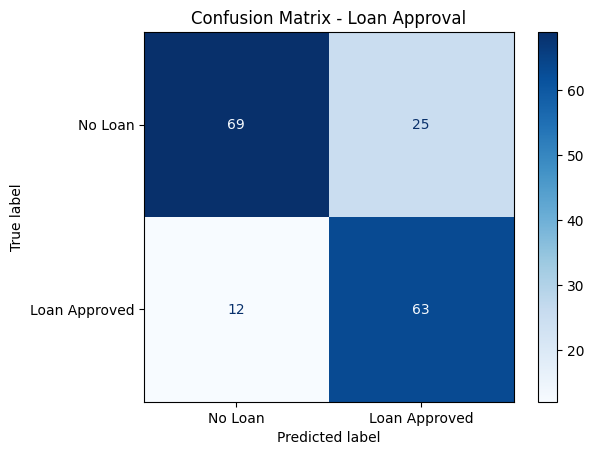

In [4]:
y_val_hat = grid.predict(X_val)
test_accuracy = accuracy_score(y_val, y_val_hat) * 100
print("Test Accuracy: {:.2f}%".format(test_accuracy))

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_val_hat))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_hat)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=["No Loan", "Loan Approved"])
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix - Loan Approval")
plt.show()


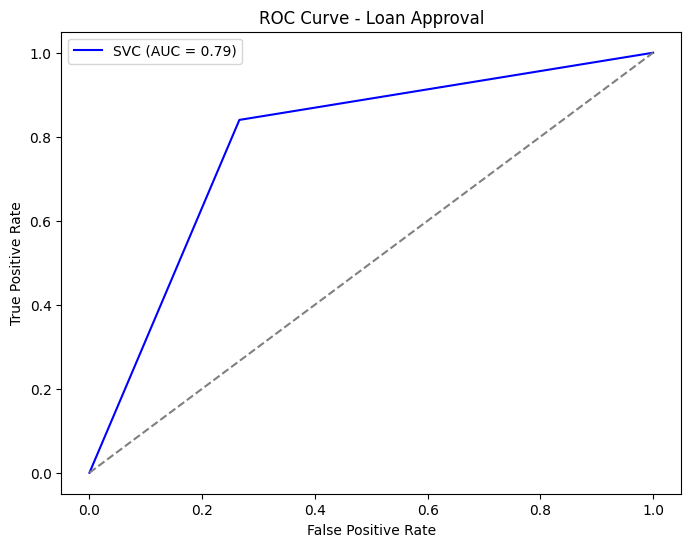

In [5]:
fpr, tpr, _ = roc_curve(y_val, y_val_hat)
roc_auc = roc_auc_score(y_val, y_val_hat)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="SVC (AUC = {:.2f})".format(roc_auc), color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Approval")
plt.legend()
plt.show()


In [6]:
df_test = pd.read_csv('loan-test.csv', index_col=0)

# Encoding categorical variables
for col in df_test.select_dtypes(include=['object']).columns:
    df_test[col] = le.fit_transform(df_test[col])

# Handling missing values using KNN Imputation
df_test_data = imputer.transform(df_test)  # Using the same imputer fitted on training data
df_test_new = pd.DataFrame(df_test_data, columns=df_test.columns)

# Applying the same scaling used for training data
df_test_scaled = scaler.transform(df_test_new)

# Making Predictions
y_pred = grid.predict(df_test_scaled)
df_test_new['Loan Status'] = y_pred

# Display Loan Approval Counts
print("Loan Status Prediction Counts:\n", df_test_new['Loan Status'].value_counts())


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Loan_Status
